### Sommaire



---


- <a href="#C0"> 0. Importation des images </a>

- <a href="#C1"> 1. OPTION -1 : Extraction des features images via VGG16 + classification classique </a>
  - <a href="#C11"> 1.1 Extraction des features via VGG <a>
  - <a href="#C12"> 1.2 Réduction de dimansion dans l'espace LDA <a>
  - <a href="#C13"> 1.3 Classification via K-Nearest Neighbor <a>
  - <a href="#C14"> 1.4 Test d'autre modèle de classification et évaluation par validation croisée <a>


- <a href="#C2"> 2. OPTION - 2 : Classification des images par VGG16 avec fine-tuning partiel </a>


- <a href="#C3"> 3. OPTION - 3 : Extraction des features images via VGG16 + Classification textuelle </a>
  - <a href="#C31"> 3.1 Préparation de la collection d'image <a>
  - <a href="#C32"> 3.2 Extraction des features textuelles à l'aide du modèle USE<a>
  - <a href="#C33"> 3.3 Évaluation du modèle <a>



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import re
import seaborn as sns
import missingno as msno
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

#---------- NLTK
! pip install --user -U nltk
! pip install word2vec
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('words')
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

! pip install plot-keras-history


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=143975 sha256=39f5baf063e4f9f98a0bda58b794cf69d53ce3b8480010486feeae5bcda0a9e1
  Stored in directory: /root/.cache/pip/wheels/6a/fa/d1/e03e8c10e0e2aa5c7b6e2b46b4a1c715d140283853937bb4b1
Successfully built word2vec


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9457 sha256=6ae9fe4592bd1acebe77609b9b79bb473ddc0aec2e4ef4cf603680dc6b393f08
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320501 sha256=2905e931ebc663306779281300ed72abe84160669fd5a6e1286d029a81edc282
  Stored in directory: /root/.cache/pip/wheels/b7/f3/5d/748143833c99806921d4e1182c248876b83464746ef1e46f1d
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=ea8a7aa51c3a1de0a24d144d243a4bd1ae69da0a24d33cc89c9cbf997fc0e8d5
  Stored in director

# <a name="C0"> 0. Importation des images <a>

In [2]:
from os import listdir
!unzip /content/Images.zip -d /content/Images

Archive:  /content/Images.zip
   creating: /content/Images/Images/
  inflating: /content/Images/__MACOSX/._Images  
  inflating: /content/Images/Images/aa68675f50a0551b8dadb954017a50a1.jpg  
  inflating: /content/Images/__MACOSX/Images/._aa68675f50a0551b8dadb954017a50a1.jpg  
  inflating: /content/Images/Images/037c2402fee39fbc80433935711d1383.jpg  
  inflating: /content/Images/__MACOSX/Images/._037c2402fee39fbc80433935711d1383.jpg  
  inflating: /content/Images/Images/42643c1c9403f67921a18654bcf45ead.jpg  
  inflating: /content/Images/__MACOSX/Images/._42643c1c9403f67921a18654bcf45ead.jpg  
  inflating: /content/Images/Images/53f4bc7d7321f5c41de6b86e41f13e80.jpg  
  inflating: /content/Images/__MACOSX/Images/._53f4bc7d7321f5c41de6b86e41f13e80.jpg  
  inflating: /content/Images/Images/b144a363c107c7bdd91f32d6e28ba6f2.jpg  
  inflating: /content/Images/__MACOSX/Images/._b144a363c107c7bdd91f32d6e28ba6f2.jpg  
  inflating: /content/Images/Images/db3e2eeb4fe90d4755f2911d661eae95.jpg  
  in

In [3]:
path = "/content/Images/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [4]:
df = pd.read_csv('/content/flipkart_com-ecommerce_sample_1050.csv')

In [5]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


In [6]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
df['category'] = df['product_category_tree']
for i, it in df['category'].items():
  ls = []
  ls = tokenizer.tokenize(it)
  df['category'].loc[i] = ls[0]

In [7]:
df.groupby("category")['image'].count()

category
Baby         150
Beauty       150
Computers    150
Home         300
Kitchen      150
Watches      150
Name: image, dtype: int64

In [8]:
df_class = df[['image','category']]

In [9]:
df_class

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby


### Vérification des doublons

In [10]:
clean.doublon(df_class, 'image')

Recherche de doublon : il y a  0 
doublons qui ont la même clé: image


,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home
691,c65fa0b38ab99792630468bd7dd26416.jpg,Beauty
692,142994b421c052a6193052c6c8c3d076.jpg,Beauty
693,c6adf41cd378b1f6a7ac62675b060411.jpg,Home
694,0ae859a69c7608d8197c3ba8c37bc6ec.jpg,Home
...,...,...
356,9a02f44389bda4c60e7dc23947dbca58.jpg,Beauty
357,79b78739b0ae84780001fec304ce036c.jpg,Beauty
358,91e22428c0dd8871288ba5dac35a7382.jpg,Beauty
360,cc9412969fab14faba65c70e00fef4a8.jpg,Beauty


### Tests

Home
/content/Images/Images/57578c1e6ec61a880a6f3f971f5f77b8.jpg
/content/Images/Images/4e130ed339dcfe20d2c8b66892278a94.jpg
/content/Images/Images/374e63028d691c380bc43b0dc60e460d.jpg


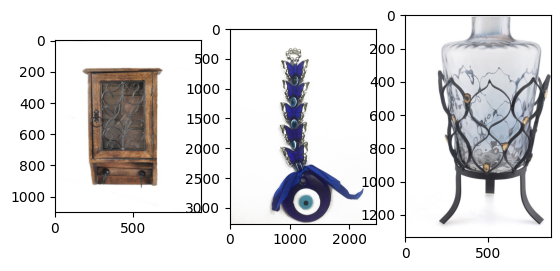

Baby
/content/Images/Images/184ecf07ca4e2872eaf53d2344a1e783.jpg
/content/Images/Images/f1ee63a5f0db853e2c1b377778580d39.jpg
/content/Images/Images/8015db34d09642b046c775e8157dd729.jpg


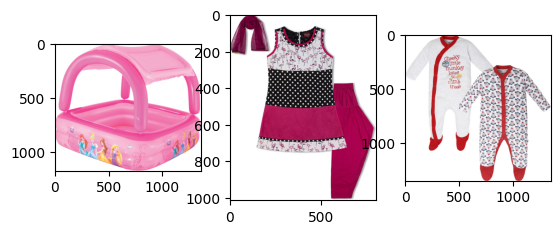

Watches
/content/Images/Images/733aa1e801a139fa8dc7be9f0eff5ee0.jpg
/content/Images/Images/62c35de4df27437d3597963fac55a8b6.jpg
/content/Images/Images/33d97d63c037078cd3f08033966d6a88.jpg


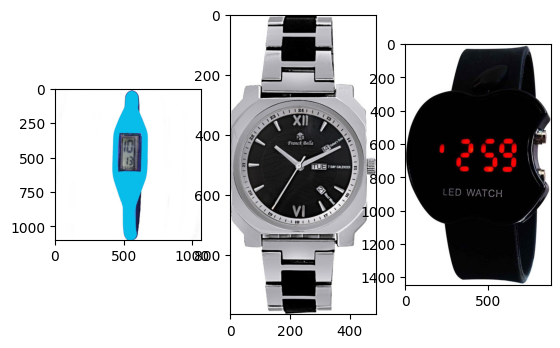

Kitchen
/content/Images/Images/9ba898ecb77ab5a6799c8b047c6b6008.jpg
/content/Images/Images/afc3ebd18df498dd87abb7ad7536b5c7.jpg
/content/Images/Images/0096e89cc25a8b96fb9808716406fe94.jpg


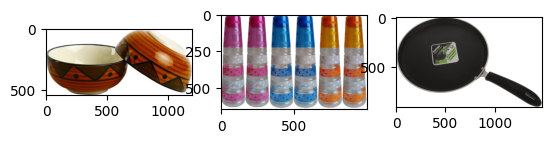

Beauty
/content/Images/Images/059493eeb88ebb4cc08d1522f3f87c3f.jpg
/content/Images/Images/9613f2f1e65fb1fc7e181e7f83c217da.jpg
/content/Images/Images/640fd08bb3ba538d67a5c0c2c61a5c4c.jpg


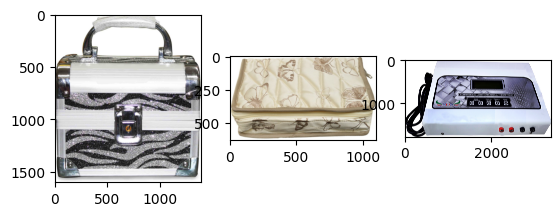

Computers
/content/Images/Images/fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg
/content/Images/Images/5df72b5295dc5e6126693e640b50f3a2.jpg
/content/Images/Images/f309bdd259c5b46a560bc1620e641947.jpg


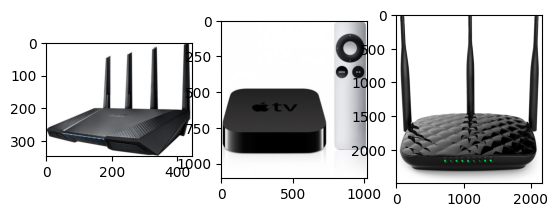

In [11]:
from matplotlib.image import imread
def list_fct(name) :
    df_tamp = df[df['category'] == name]
    list_image_name = df_tamp['image'].tolist()
    return list_image_name

list_labels = df['category'].unique().tolist()

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+12]
        print(filename)
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [12]:
df[df['uniq_id']== '486e98154514ed485f0b2f9bc9f24549']

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
922,486e98154514ed485f0b2f9bc9f24549,2016-01-01 13:15:34 +0000,http://www.flipkart.com/agrasen-international-...,Agrasen International Radha Krishna Statue Sho...,"[""Home Decor & Festive Needs >> Table Decor & ...",SHIE6QFEJYJ5YEGW,1000.0,599.0,486e98154514ed485f0b2f9bc9f24549.jpg,False,Buy Agrasen International Radha Krishna Statue...,No rating available,No rating available,Agrasen International,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home


In [13]:
l_cat = list(set(df['category']))
l_cat

['Watches', 'Computers', 'Beauty', 'Kitchen', 'Home', 'Baby']

# <a name="C1"> 1. Classification des images par KNN (jeu d'entraînement VGG16) - stratégie 1 <a>

### Stratégie 1  : extraction des features puis entraînement du KNN Classifier


---
**Partie 1**

1.   On récupère le modèle VGG16 pré-entraîné sur 15 millions d'images.
2.   On limite l'utilisation du VGG à l'extraction de feature en désactivant la dernière couche fully-connected.
3.   J'importe les images au format 224x224 et je les mets sous forme vectoriel 224x224x3
4.   J'utilise un .predict sur mes images pour obtenir les features en me basant sur le jeu d'entraînement propre au VGG16.

5. Je sépare mes données en set d'entraînement et en set de test.

5. Création d'un pipeline :
    * Standardisation
    * Réduction de dimension via Linear Discriminant Analysis
    * KNN Classifier.
6. Test du modèle sur mon jeu test.
7. Evaluation du modèle par validation croisée, puis test.
8. Analyse par classes



## <a name="C11"> 1.1 Extraction des features via VGG <a>

In [14]:
base_model = VGG16() #on instancie le modèle de base sans paramètre particulier
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 17s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- ### Extraction des features des images

In [16]:
df_class.head()

,image,category,NB_NAN
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home,0
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home,0
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home,0


In [17]:
images_features = []
i=0
#df_class = df_class.sample(150)
ind_sample = df_class.index

for image_file in df_class["image"]: #.loc[ind_sample] : #Échantillon de 300 images
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(path+image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600
700
800
900
1000


(1050, 4096)

## <a name="C12"> 1.2 Réduction de dimension dans l'espace LDA <a>

In [18]:
y = df_class['category'].values
ind_ = df_class.index

In [19]:
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(images_features, y, ind_, test_size=0.2, random_state=42,
                                                                         stratify = y)
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

In [20]:
#Dataframe qui me permettra de comparer les performances des différents modèles
df_analyse = df_class[['image', 'category']]
df_analyse = df_analyse.loc[ind_test]

### Vérification du *stratify*



<Axes: xlabel='count', ylabel='target'>

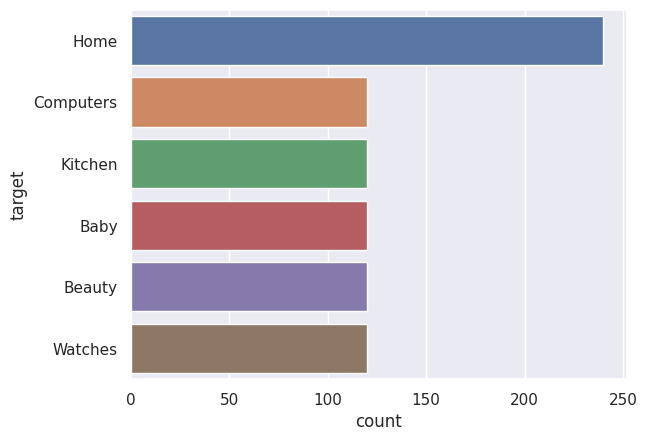

In [21]:
df_train = pd.DataFrame(X_train, index = ind_train)
df_train['target'] = y_train
sns.set()
sns.countplot(data = df_train, y = 'target')

<Axes: xlabel='count', ylabel='target'>

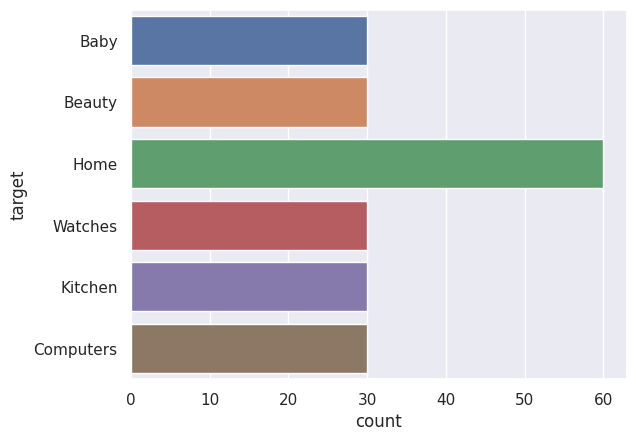

In [22]:
df_test = pd.DataFrame(X_test, index = ind_test)
df_test['target'] = y_test
sns.set()
sns.countplot(data = df_test, y = 'target')

### Réduction de dimension

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1)
X_r2_train = lda.fit(X_train_scaled, y_train).transform(X_train_scaled)

In [24]:
X_r2_test = lda.transform(X_test_scaled)
X_r2_tot = np.concatenate((X_r2_train, X_r2_test), axis=0)
ind_tot = np.concatenate((ind_train, ind_test), axis=0)
df_lda = pd.DataFrame(X_r2_tot, columns=['Dim1', 'Dim2','Dim3','Dim4','Dim5'])
df_lda['category'] = df_class['category'].loc[ind_tot].values
df_lda['product'] = df['product_name'].loc[ind_tot].values
df_lda['indice'] = ind_tot

In [25]:
df_lda

,Dim1,Dim2,Dim3,Dim4,Dim5,category,product,indice
0,6.414824,7.962675,1.126674,-3.502696,5.935494,Home,R&Mshoppee MDF Wall Shelf,600
1,-0.698224,-9.825656,-13.946121,-5.943100,0.777372,Computers,Huawei WS331c -300 Mbps Wireless Range Extender,324
2,1.996090,-15.077514,13.615541,-2.237089,-0.334612,Kitchen,Rockmantra Water Fire Ceramic Mug,173
3,-0.284899,-10.206385,-14.689328,-5.733809,0.489865,Computers,Asus DSL-N10_C1,391
4,6.594702,5.772124,-0.428616,-0.623541,-12.780221,Baby,MH MDF Photo Frame,670
...,...,...,...,...,...,...,...,...
1045,-3.865050,-3.182673,-2.192905,-5.671327,-1.315139,Home,Ruchikainternational ruc0015 Showpiece - 4 cm,258
1046,5.125998,6.228094,-0.845782,2.818905,9.892052,Home,Lal Haveli Rajasthani Wooden Crafted Unique Ch...,201
1047,5.924461,9.420591,-1.014607,5.818844,4.100085,Baby,Indha Craft Cloth Photo Frame,672
1048,4.918926,-4.136278,-6.947926,21.222613,5.596131,Beauty,Oxyglow Lacto Bleach & Fruit Massage Cream Wit...,809


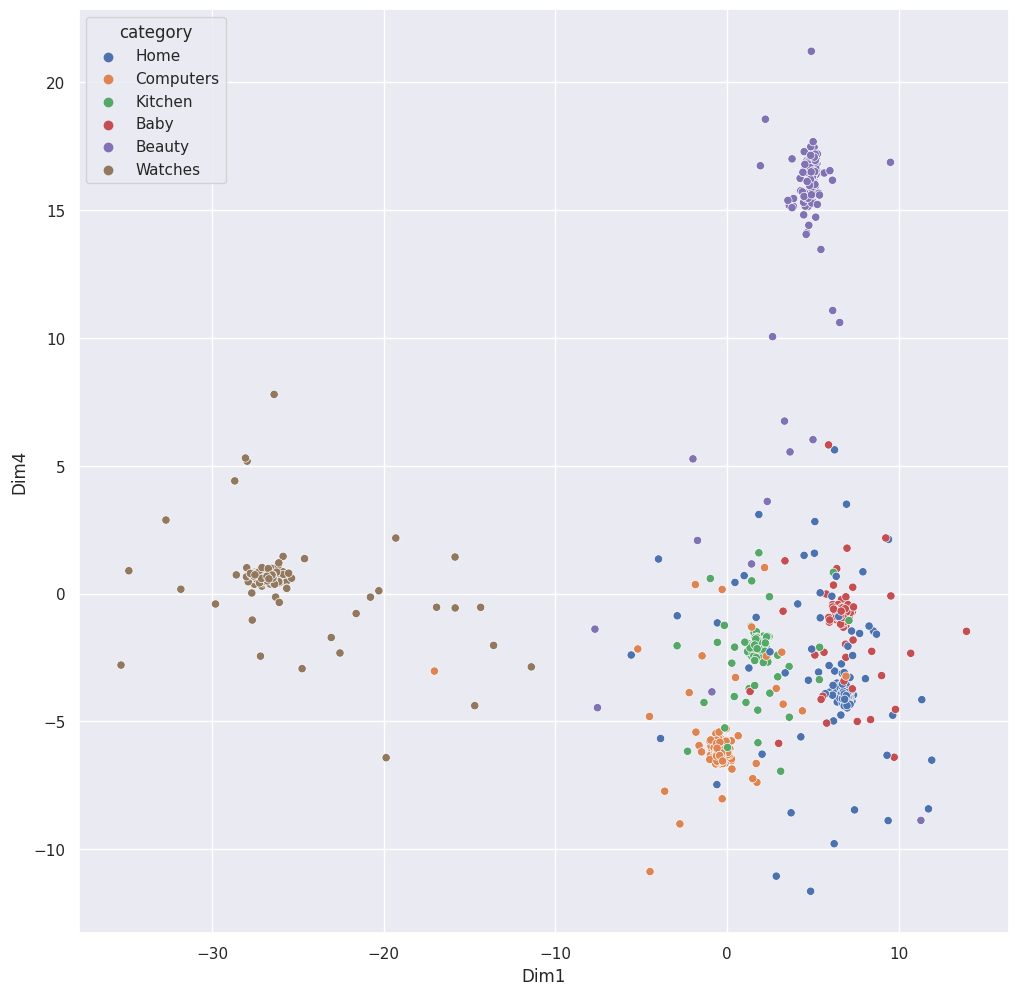

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(data= df_lda, x='Dim1', y='Dim4',hue = 'category')
plt.savefig('/content/Fichier_N2/P6_N2_22.png', bbox_inches = 'tight')
plt.show()

## <a name="C13"> 1.3 Classification via K-nearest neighbor <a>

### Baseline de classification

In [28]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_r2_train,y_train)
y_pred_dummy = dummy_clf.predict(X_r2_test)
error_rate = np.mean(y_pred_dummy != y_test)
print(error_rate)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_dummy))

0.8523809523809524
              precision    recall  f1-score   support

        Baby       0.10      0.13      0.11        30
      Beauty       0.11      0.13      0.12        30
   Computers       0.21      0.23      0.22        30
        Home       0.30      0.17      0.22        60
     Kitchen       0.09      0.10      0.09        30
     Watches       0.10      0.10      0.10        30

    accuracy                           0.15       210
   macro avg       0.15      0.14      0.14       210
weighted avg       0.17      0.15      0.15       210



In [29]:
cf = confusion_matrix(y_test, y_pred_dummy)
cf

array([[ 4,  6,  1,  7,  9,  3],
       [ 9,  4,  7,  5,  2,  3],
       [ 4,  5,  7,  3,  6,  5],
       [ 9,  7, 10, 10, 11, 13],
       [ 8,  5,  4,  7,  3,  3],
       [ 8, 10,  4,  1,  4,  3]])

In [30]:
df_analyse['dummy'] = y_pred_dummy

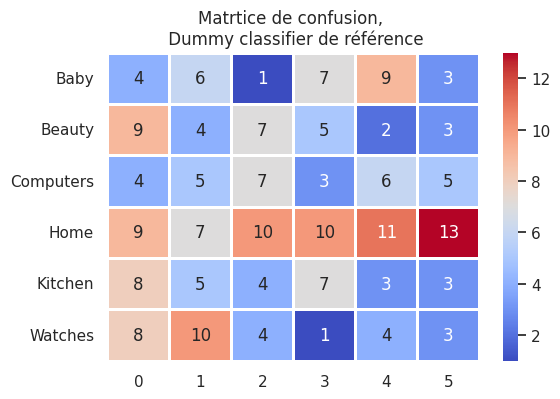

In [31]:
df_cm = pd.DataFrame(cf, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)
plt.title('Matrtice de confusion, \n Dummy classifier de référence')
plt.savefig('/content/Fichier_N2/P6_N2_13_Dummy.png', bbox_inches = 'tight')




### Recherche de la valeur optimale de *k*

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
## Recherche de la valeur optimale de k
for k in range(1,30):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_r2_train,y_train)
  pred_i = neigh.predict(X_r2_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rate,color='blue', linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:",min(error_rate),"at K =",error_rate.index(min(error_rate))+1)

je choisie de garder la valeur :


```
k = error_rate.index(min(error_rate))+1
```



### Analyse par classes

In [ ]:
y_pred = neigh.predict(X_r2_test)
print(classification_report(y_test, y_pred))

In [ ]:
cf = confusion_matrix(y_test, y_pred)
cf

In [ ]:
#Teste de la matrice de confusion pour la dernière valeur de k
df_cm = pd.DataFrame(cf, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)

## <a name="C14"> 1.4 Évaluation du modèle <a>



---


Test : Je teste deux modèles de prédictions :


*   KNN
*   LDA

L'opérateur LDA (Linear Discriminant Analysis) est à la fois un moyen de réduction de dimension, de classification. J'aimerais comparer les performances des deux modèles.


### Création d'un pipeline

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

mod = 'svc' #'lda' ou 'knn'
k = error_rate.index(min(error_rate))+1

if mod == 'knn':
  Class_pipe = Pipeline([('scaler', StandardScaler()),
                           ('LDA', LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1)),
                           ('KNN', KNeighborsClassifier(n_neighbors=k))])

  score = cross_val_score(Class_pipe, X_train, y_train, cv=6)
  score_moy = np.mean(score)
elif mod == 'lda':
  Class_pipe= Pipeline([('scaler', StandardScaler()),
                           ('LDA', LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1))])

  score = cross_val_score(Class_pipe, X_train, y_train, cv=6)
  score_moy = np.mean(score)
elif mod == 'svc':
  Class_pipe = Pipeline([('scaler', StandardScaler()),
                           ('LDA', LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1)),
                           ('SVC', SVC(kernel = 'linear'))])
  score = cross_val_score(Class_pipe, X_train, y_train, cv=6)
  score_moy = np.mean(score)

In [ ]:
print('Le score moyen d\'accuracy issu de la validation croisée est', round(score_moy,2))

In [ ]:
Class_pipe.fit(X_train,y_train)

In [ ]:
if mod == 'lda':
  y_pred_lda = Class_pipe.predict(X_test)
  print(classification_report(y_test, y_pred_lda))
  df_analyse['LDA'] = y_pred_lda
  cf = confusion_matrix(y_test, y_pred_lda)
elif mod == 'knn':
  y_pred_knn = Class_pipe.predict(X_test)
  print(classification_report(y_test, y_pred_knn))
  df_analyse['KNN'] = y_pred_knn
  cf = confusion_matrix(y_test, y_pred_knn)
elif mod == 'svc':
  y_pred_svc = Class_pipe.predict(X_test)
  print(classification_report(y_test, y_pred_svc))
  df_analyse['SVC'] = y_pred_svc
  cf = confusion_matrix(y_test, y_pred_svc)

In [ ]:
cf

In [ ]:
df_cm = pd.DataFrame(cf, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)
plt.title('Matrice de confusion \n modèle '+str(mod).upper())
plt.savefig('/content/Fichier_N2/P6_N2_14_'+str(mod)+'.png',  bbox_inches = 'tight')

- ### Analyse par classe

In [ ]:
df_analyse

In [ ]:
# Sélection aléatoire d'une image mal classé par les deux

# <a name="C2"> 2. Classification des images par VGG16 (jeu d'entraînement VGG16 + data flipkart) - startégie 2 <a>

### Stratégie 2 : Entraînement des couches hautes du réseau avec le jeu d'entaînement + entrâinement d'une couche de prédiction


---

1.   On récupère le modèle VGG16 pré-entraîné sur 15 millions d'images.
2.   On désactive la dernière couche fully-connected.
3.   J'importe les images au format 224x224 et je les mets sous forme vectoriel 224x224x3
5. Je sépare mes données en set d'entraînement et en set de test.
4. Je précise les couches fixes et les couches à entraîner à nouveau avec mon jeu d'entraînement.
5. J'ajoute une couche de prédiction
4. J'entrâine le modèle

6. Test du modèle sur mon jeu test.




---

Je choisis d'échantillonner mon modèle car l'entraînement du VGG :



*   Environ 20h de calcul pour 50 epoch, pour le réentraînement des couches du VGG16 excepté les 5 premières, pour un dataset de 1000 photos.





In [ ]:
df_class = df_class.drop(columns = 'NB_NAN')

- ### Échantillonage




In [ ]:
#df_class = df_class.sample(300)
#ind_ = df_class.index

- ### Préparation de la collection d'image

In [ ]:
def image_prep_fct(data, ind_) :
  i=0
  prepared_images = []
  for image_num in ind_ :
      #print(image_num)
      if i%100 == 0 : print(i)
      i +=1
      #print(i)
      img = (load_img(
            path+data['image'][image_num],
            target_size=(224, 224)))
      #print(path)
      img = img_to_array(img)
      img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
      img = preprocess_input(img)
      prepared_images.append(img)
      prepared_images_np = np.array(prepared_images)
  return prepared_images_np

In [ ]:
images = image_prep_fct(df_class, ind_)

0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
#Vérification
print(images.shape)

(1050, 224, 224, 3)


In [ ]:
X = images
#----------------------------------- Label Encoder ----------------------------------------
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ls_cat = df_class['category'].unique().tolist()
le.fit(ls_cat)

y = df_class['category']
y = le.transform(y)
#---------------------------------- split du dataset en train et test sets ------------------
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, ind_, test_size=0.2, random_state=42,
                                                                         stratify = y)

- ### Construction du modèle

In [ ]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers[:]: #modèle 2 : aucune couche entraînable #modèle trois : 10 dertnières couches entraînables
    #modele 4 : les 5 premières couches fixes
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x) #GlobalMax Pooling
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(6, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="sparse_categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


In [ ]:
with tf.device('/gpu:0'):
  model_2 = create_model_fct()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Création du callback
model_2_save_path = "content/model_2_best_weights.h5"
checkpoint = ModelCheckpoint(model_2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

In [ ]:
X_train_v, X_val, y_train_v, y_val, ind_train_v, ind_val = train_test_split(X_train, y_train, ind_train, test_size=0.2, random_state=42,
                                                                         stratify = y_train)

- ### Entraînement

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history_model_2 = model_2.fit(X_train_v, y_train_v, epochs=50, batch_size=64, #essai avec epochs = 50
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

#20 min temps d'entraînement en entraînant que le classifieur.
# 32 min en entraînant les

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 4.9818 - accuracy: 0.5134 
Epoch 1: val_loss improved from inf to 1.58119, saving model to content/model_2_best_weights.h5
11/11 [==============================] - 502s 47s/step - loss: 4.9818 - accuracy: 0.5134 - val_loss: 1.5812 - val_accuracy: 0.7202
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 2.0798 - accuracy: 0.7113 
Epoch 2: val_loss did not improve from 1.58119
11/11 [==============================] - 440s 41s/step - loss: 2.0798 - accuracy: 0.7113 - val_loss: 1.6886 - val_accuracy: 0.7560
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.2386 - accuracy: 0.7932 
Epoch 3: val_loss improved from 1.58119 to 1.27124, saving model to content/model_2_best_weights.h5
11/11 [==============================] - 496s 46s/step - loss: 1.2386 - accuracy: 0.7932 - val_loss: 1.2712 - val_accuracy: 0.7500
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 0.8172 - ac

In [ ]:
! pip install plot-keras-history

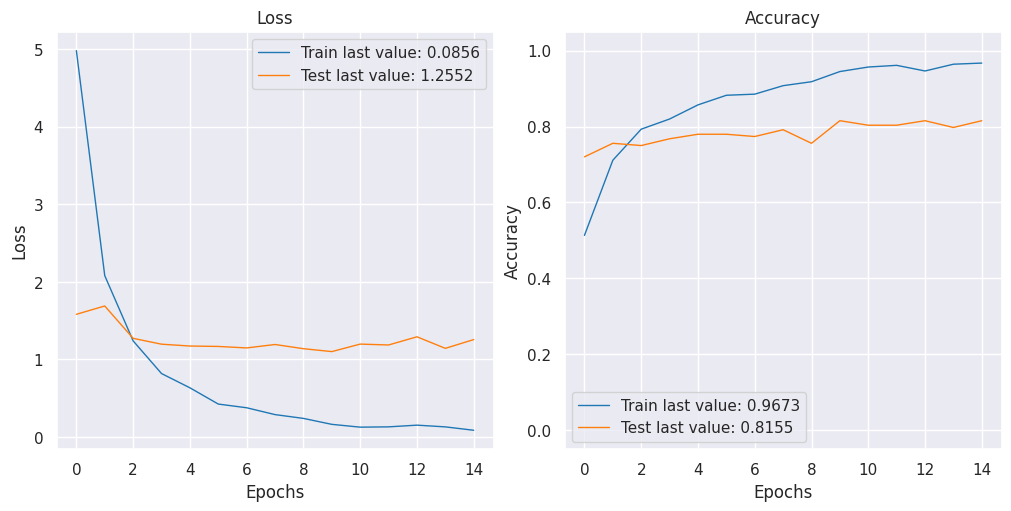

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history_model_2)
plot_history(history_model_2, path="standard.png")
plt.close()

In [ ]:
y_pred_vgg16 = np.argmax(model_2.predict(X_test), axis = 1)

7/7 [==============================] - 135s 18s/step


In [ ]:
y_test

array([0, 1, 3, 1, 1, 5, 0, 3, 3, 3, 3, 4, 2, 5, 4, 4, 3, 3, 3, 3, 2, 2,
       0, 0, 5, 2, 4, 5, 1, 4, 3, 3, 3, 5, 0, 5, 2, 0, 0, 2, 3, 3, 5, 3,
       3, 5, 1, 0, 5, 5, 3, 4, 3, 4, 0, 0, 4, 2, 5, 2, 0, 0, 2, 0, 5, 3,
       2, 4, 4, 5, 3, 1, 3, 4, 4, 0, 3, 1, 2, 1, 2, 4, 3, 5, 3, 0, 2, 0,
       2, 3, 2, 1, 2, 1, 5, 2, 4, 3, 3, 3, 3, 2, 4, 3, 5, 1, 4, 3, 5, 1,
       3, 0, 4, 3, 5, 3, 3, 1, 4, 3, 1, 5, 3, 1, 5, 2, 3, 1, 3, 0, 5, 1,
       1, 5, 4, 0, 5, 4, 5, 5, 5, 3, 3, 3, 5, 1, 1, 3, 1, 3, 3, 4, 4, 2,
       1, 4, 5, 0, 3, 0, 3, 3, 2, 4, 3, 2, 5, 3, 0, 3, 1, 1, 4, 1, 4, 4,
       0, 4, 2, 0, 2, 3, 3, 2, 3, 2, 5, 3, 3, 1, 2, 1, 4, 2, 1, 3, 0, 2,
       0, 4, 1, 2, 3, 0, 0, 3, 3, 0, 1, 0])

In [ ]:
y_test = le.inverse_transform(y_test)
y_pred_vgg16 = le.inverse_transform(y_pred_vgg16)

In [ ]:
y_pred_vgg16

- ### Résultat

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred_vgg16)
print(conf_mat)

[[16  1  0 12  1  0]
 [ 0 22  2  4  1  1]
 [ 0  0 21  5  3  1]
 [ 8  0  0 50  2  0]
 [ 0  0  1  1 28  0]
 [ 0  0  2  0  0 28]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_vgg16))

              precision    recall  f1-score   support

        Baby       0.67      0.53      0.59        30
      Beauty       0.96      0.73      0.83        30
   Computers       0.81      0.70      0.75        30
        Home       0.69      0.83      0.76        60
     Kitchen       0.80      0.93      0.86        30
     Watches       0.93      0.93      0.93        30

    accuracy                           0.79       210
   macro avg       0.81      0.78      0.79       210
weighted avg       0.79      0.79      0.78       210



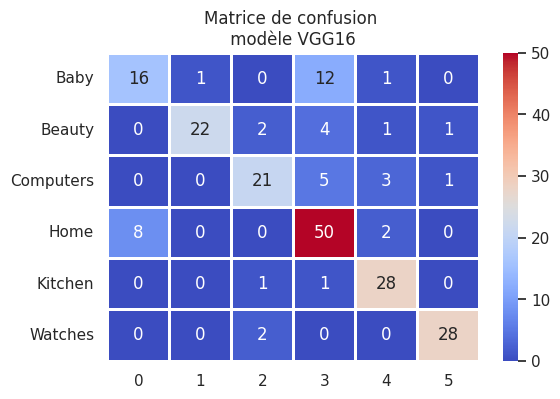

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)
plt.title('Matrice de confusion \n modèle VGG16 ')
plt.savefig('/content/Fichier_N2/P6_N2_2_VGG16.png', bbox_inches = 'tight')

In [ ]:
df_analyse['VGG16'] = y_pred_vgg16
df_analyse

,image,category,dummy,KNN,LDA,VGG16
647,3dfd14b667357e26ff6d66761cdc203f.jpg,Baby,Watches,Baby,Baby,Home
342,17a73d7c4b02ada2bfeed1115fed08a4.jpg,Beauty,Computers,Beauty,Beauty,Beauty
752,83cef279f0ea5d772523d0d8b2923fbe.jpg,Home,Baby,Home,Home,Home
56,24e85c590481a7cedfe66597f253f2b2.jpg,Beauty,Watches,Home,Home,Home
386,59d964c38c787f829c6cfa5629e4df90.jpg,Beauty,Baby,Beauty,Beauty,Beauty
...,...,...,...,...,...,...
258,9833d0de7f7e1927c807411c10b19189.jpg,Home,Beauty,Computers,Computers,Home
201,9c4ab8ab059c912090c83cb0818e7f1c.jpg,Home,Baby,Home,Home,Home
672,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,Baby,Computers,Home,Home,Home
809,1d1be744e491ed61e705c20e4a72320d.jpg,Beauty,Home,Beauty,Beauty,Beauty


# <a name="C3"> 3. Classification des images par VGG16 (jeu d'entraînement VGG16) + classification textuelle - stratégie 3 <a>

Stratégie 3

---


1.   Utiliser le modèle VGG16 classique
2.   Extraire la prédiction parmis les 1000 catégorie
3.   Utiliser l'analyse textuelle des mots, BERT ou word2vec ou LDA pré-entraîné sur le jeu d'entraînement et en déduire une catégorie.





In [ ]:
ind_ = df_class.index

In [ ]:
base_model = VGG16() #on instancie le modèle de base sans paramètre particulier
print(base_model.summary())

## <a name="C31"> 3.1 Préparation de la collection d'image <a>

In [ ]:
#Vérification
print(images.shape)

(1050, 224, 224, 3)


In [ ]:
X = images
#----------------------------------- Label Encoder ----------------------------------------
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ls_cat = df_class['category'].unique().tolist()
le.fit(ls_cat)

y = df_class['category']
y = le.transform(y)
#---------------------------------- split du dataset en train et test sets ------------------
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, ind_, test_size=0.2, random_state=42,
                                                                         stratify = y)

In [ ]:
#Création d'u corpus
data_train = base_model.predict(X_train)
data_test = base_model.predict(X_test)

7/7 [==============================] - 169s 24s/step


In [ ]:
def prediction_dataframe(data_, ind_):
  ## Récupère la prédiction du modèle VGG16 et la décode
  new_corpus = pd.DataFrame(columns = ['label', 'ind_'])
  size_data = data_.shape[0]
  for i in range(size_data):
    im = np.expand_dims(data_[i], axis=0) #Je reshape pour avoir un tenseur de taille (1, 1000)
    label_train = decode_predictions(im)
    new_corpus.loc[i, 'ind_'] = ind_[i]
    text = label_train[0][0][1]
    #print(text)
    new_corpus.loc[i, 'label'] = text
  return new_corpus

In [ ]:
corpus_train = prediction_dataframe(data_train, ind_train)
corpus_test = prediction_dataframe(data_test, ind_test)

In [ ]:
corpus_train

,label,ind_
0,dining_table,600
1,switch,324
2,coffee_mug,173
3,modem,391
4,lotion,670
...,...,...
835,hook,207
836,lipstick,924
837,wool,35
838,radio,800


In [ ]:
corpus_test

,label,ind_
0,overskirt,647
1,water_bottle,342
2,studio_couch,752
3,sandal,56
4,lotion,386
...,...,...
205,magnetic_compass,258
206,totem_pole,201
207,wallet,672
208,lotion,809


In [ ]:
repl = ' '
corpus_train['label'] = corpus_train['label'].str.replace('_', repl)
corpus_test['label'] = corpus_test['label'].str.replace('_', repl)
#for i, lab in data_train['label'].items():
#  data_train['label'].loc[i] = lab[-1]

In [ ]:
corpus_train

,label,ind_
0,dining table,600
1,switch,324
2,coffee mug,173
3,modem,391
4,lotion,670
...,...,...
835,hook,207
836,lipstick,924
837,wool,35
838,radio,800


In [ ]:
corpus_test

,label,ind_
0,overskirt,647
1,water bottle,342
2,studio couch,752
3,sandal,56
4,lotion,386
...,...,...
205,magnetic compass,258
206,totem pole,201
207,wallet,672
208,lotion,809


## <a name="C32"> 3.2 Extraction des features textuelles à l'aide du modèle USE<a>

In [ ]:
import tensorflow_hub as hub
import time

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
X_train = corpus_train['label'].tolist()
X_test = corpus_test['label'].tolist()

In [ ]:
#X_test

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
sentences_train = X_train
sentences_test = X_test

In [ ]:
features_USE_train = feature_USE_fct(sentences_train, 20)
features_USE_test = feature_USE_fct(sentences_test, 21)

In [ ]:
features_USE_test.shape
features_USE_train.shape

(840, 512)

Test avec Word2vec



```
#from gensim.models import Word2Vec as w2v
#import gensim.downloader as api
#wv = api.load('word2vec-google-news-300')

vocab = wv.key_to_index
vocab['laptop']
```
---

```
def matrice_w2v (corpus, ind):
  X_emb = pd.DataFrame(index = ind, columns=np.arange(300))
  for i, row in corpus.iterrows():
    label = row['label']
    j = row['ind_']
    if label in wv.key_to_index:
      X_emb.iloc[i] = wv[label]
  return X_emb

```
---

```
X_emb =  matrice_w2v(new_corpus, ind_train)
X_emb = X_emb.dropna()
X_emb.index

[i for i in ind_train if i not in X_emb.index]
new_corpus[new_corpus['ind_'] == 746]

y_texte_train = new_corpus['category'].drop(428)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_word = LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1)
lda_word.fit(X_emb, y_texte_train).transform(X_emb)
```



## <a name="C33"> 3.3 Évaluation du modèle <a>



---


Test : Je teste deux modèles de prédictions :


*   KNN
*   LDA

L'opérateur LDA (Linear Discriminant Analysis) est à la fois un moyen de réduction de dimension, de classification. J'aimerais comparer les performances des deux modèles.


### Création d'un pipeline

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

modele_4_pipe= Pipeline([('scaler', StandardScaler()),
                        ('LDA', LinearDiscriminantAnalysis(n_components=5, solver='eigen', shrinkage=0.1))])

score = cross_val_score(modele_4_pipe, features_USE_train, y_train, cv=6)
score_moy = np.mean(score)

In [ ]:
print('Le score moyen d\'accuracy issu de la validation croisée est', round(score_moy,2))

Le score moyen d'accuracy issu de la validation croisée est 0.76


In [ ]:
modele_4_pipe.fit(features_USE_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LDA',
                 LinearDiscriminantAnalysis(n_components=5, shrinkage=0.1,
                                            solver='eigen'))])

In [ ]:
y_pred_model_4 = modele_4_pipe.predict(features_USE_test)
y_pred_model_4 = le.inverse_transform(y_pred_model_4)
y_test = le.inverse_transform(y_test)
print(classification_report(y_test, y_pred_model_4))
df_analyse['USE'] = y_pred_model_4
cf = confusion_matrix(y_test, y_pred_model_4)
cf


              precision    recall  f1-score   support

        Baby       0.64      0.53      0.58        30
      Beauty       0.74      0.77      0.75        30
   Computers       0.73      0.53      0.62        30
        Home       0.63      0.77      0.69        60
     Kitchen       0.87      0.87      0.87        30
     Watches       0.90      0.87      0.88        30

    accuracy                           0.73       210
   macro avg       0.75      0.72      0.73       210
weighted avg       0.73      0.73      0.73       210



array([[16,  2,  0, 11,  0,  1],
       [ 0, 23,  1,  6,  0,  0],
       [ 3,  1, 16,  8,  1,  1],
       [ 5,  3,  3, 46,  2,  1],
       [ 1,  1,  0,  2, 26,  0],
       [ 0,  1,  2,  0,  1, 26]])

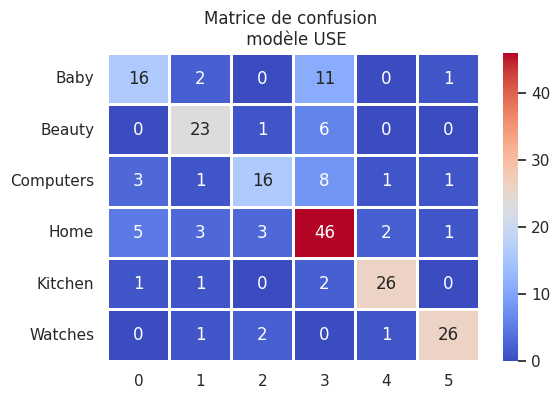

In [ ]:
df_cm = pd.DataFrame(cf, index = [label for label in ['Baby', 'Beauty', 'Computers', 'Home', 'Kitchen', 'Watches']],
                  columns = [i for i in "012345"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm,cmap='coolwarm', annot=True, linewidth=1)
plt.title('Matrice de confusion \n modèle USE')
plt.savefig('/content/Fichier_N2/P6_N2_14_USE.png',  bbox_inches = 'tight')

- ### Analyse par classe

In [ ]:
df_analyse

,image,category,dummy,KNN,LDA,VGG16,USE
647,3dfd14b667357e26ff6d66761cdc203f.jpg,Baby,Watches,Baby,Baby,Home,Home
342,17a73d7c4b02ada2bfeed1115fed08a4.jpg,Beauty,Computers,Beauty,Beauty,Beauty,Beauty
752,83cef279f0ea5d772523d0d8b2923fbe.jpg,Home,Baby,Home,Home,Home,Home
56,24e85c590481a7cedfe66597f253f2b2.jpg,Beauty,Watches,Home,Home,Home,Home
386,59d964c38c787f829c6cfa5629e4df90.jpg,Beauty,Baby,Beauty,Beauty,Beauty,Beauty
...,...,...,...,...,...,...,...
258,9833d0de7f7e1927c807411c10b19189.jpg,Home,Beauty,Computers,Computers,Home,Watches
201,9c4ab8ab059c912090c83cb0818e7f1c.jpg,Home,Baby,Home,Home,Home,Computers
672,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,Baby,Computers,Home,Home,Home,Home
809,1d1be744e491ed61e705c20e4a72320d.jpg,Beauty,Home,Beauty,Beauty,Beauty,Beauty


In [ ]:
# Sélection aléatoire d'une image mal classé par les deux